In [26]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from MODE_top_level import RegionalModel

In [3]:
# Load the region of interest
region_name = 'Vacoas'#'Port Louis'
regio_df = gpd.read_file('../model/'+region_name+'/region_geometries.geojson', crs="EPSG:3337").set_index('index')
polygon = regio_df.loc['city', 'geometry']
buffer = 5000
# Instantiate the model
model = RegionalModel(polygon=polygon, buffer_size=buffer, epsg=3337, coordinates_unit='meter')

Converted the coordinate reference system to EPSG:4326.


c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [4]:
# Load networks
model.load_networks_road('../model/'+region_name+'/networks_road/')
#model.load_network_pt('../model/'+region_name+'/networks_pt/')

In [5]:
# Load LoS tables
model.read_zippedpickles('../model/'+region_name+'/los')

walk_los: 100%|██████████| 5/5 [00:19<00:00,  3.98s/it] 


In [6]:
# Convert time to minutes
for los in [table for name, table in model.__dict__.items() if '_los' in name and len(table)>0]:
    los['time'] /= 60

In [9]:
# Cut off erronous PT trips
model.pt_los = model.pt_los.loc[model.pt_los['time']<=300]

In [10]:
# Add parking time for cars
model.auto_los['time'] += 5

# Mode choice simulation

Create mode choice probabilities for OD pairs

In [11]:
model.mode_choice('../input/Mauritius_mode_choice.xlsx', ['time'])#, time_range='generic')

  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\m.arnz\code\quetzal-lite\quetzal\engine\nested_logit.py:258: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  rank_probabilities_s = rounded.stack().stack()
 10%|█         | 1/10 [00:08<01:16,  8.54s/it]c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\m.arnz\code\quetzal-lite\quetzal\engine\nested_logit.py:258: FutureWarning: The previous implementation of stack

In [12]:
model.probabilities.sample(2)

route_type,origin,destination,segment,root,pt,car,walk,bicycle
105599,1222953224,1326438233,Persona 8,1,0.0,0.000162,0.999829,0.000008
171613,4980487721,1213575815,Persona 6,1,0.0,0.000166,0.999826,0.000008


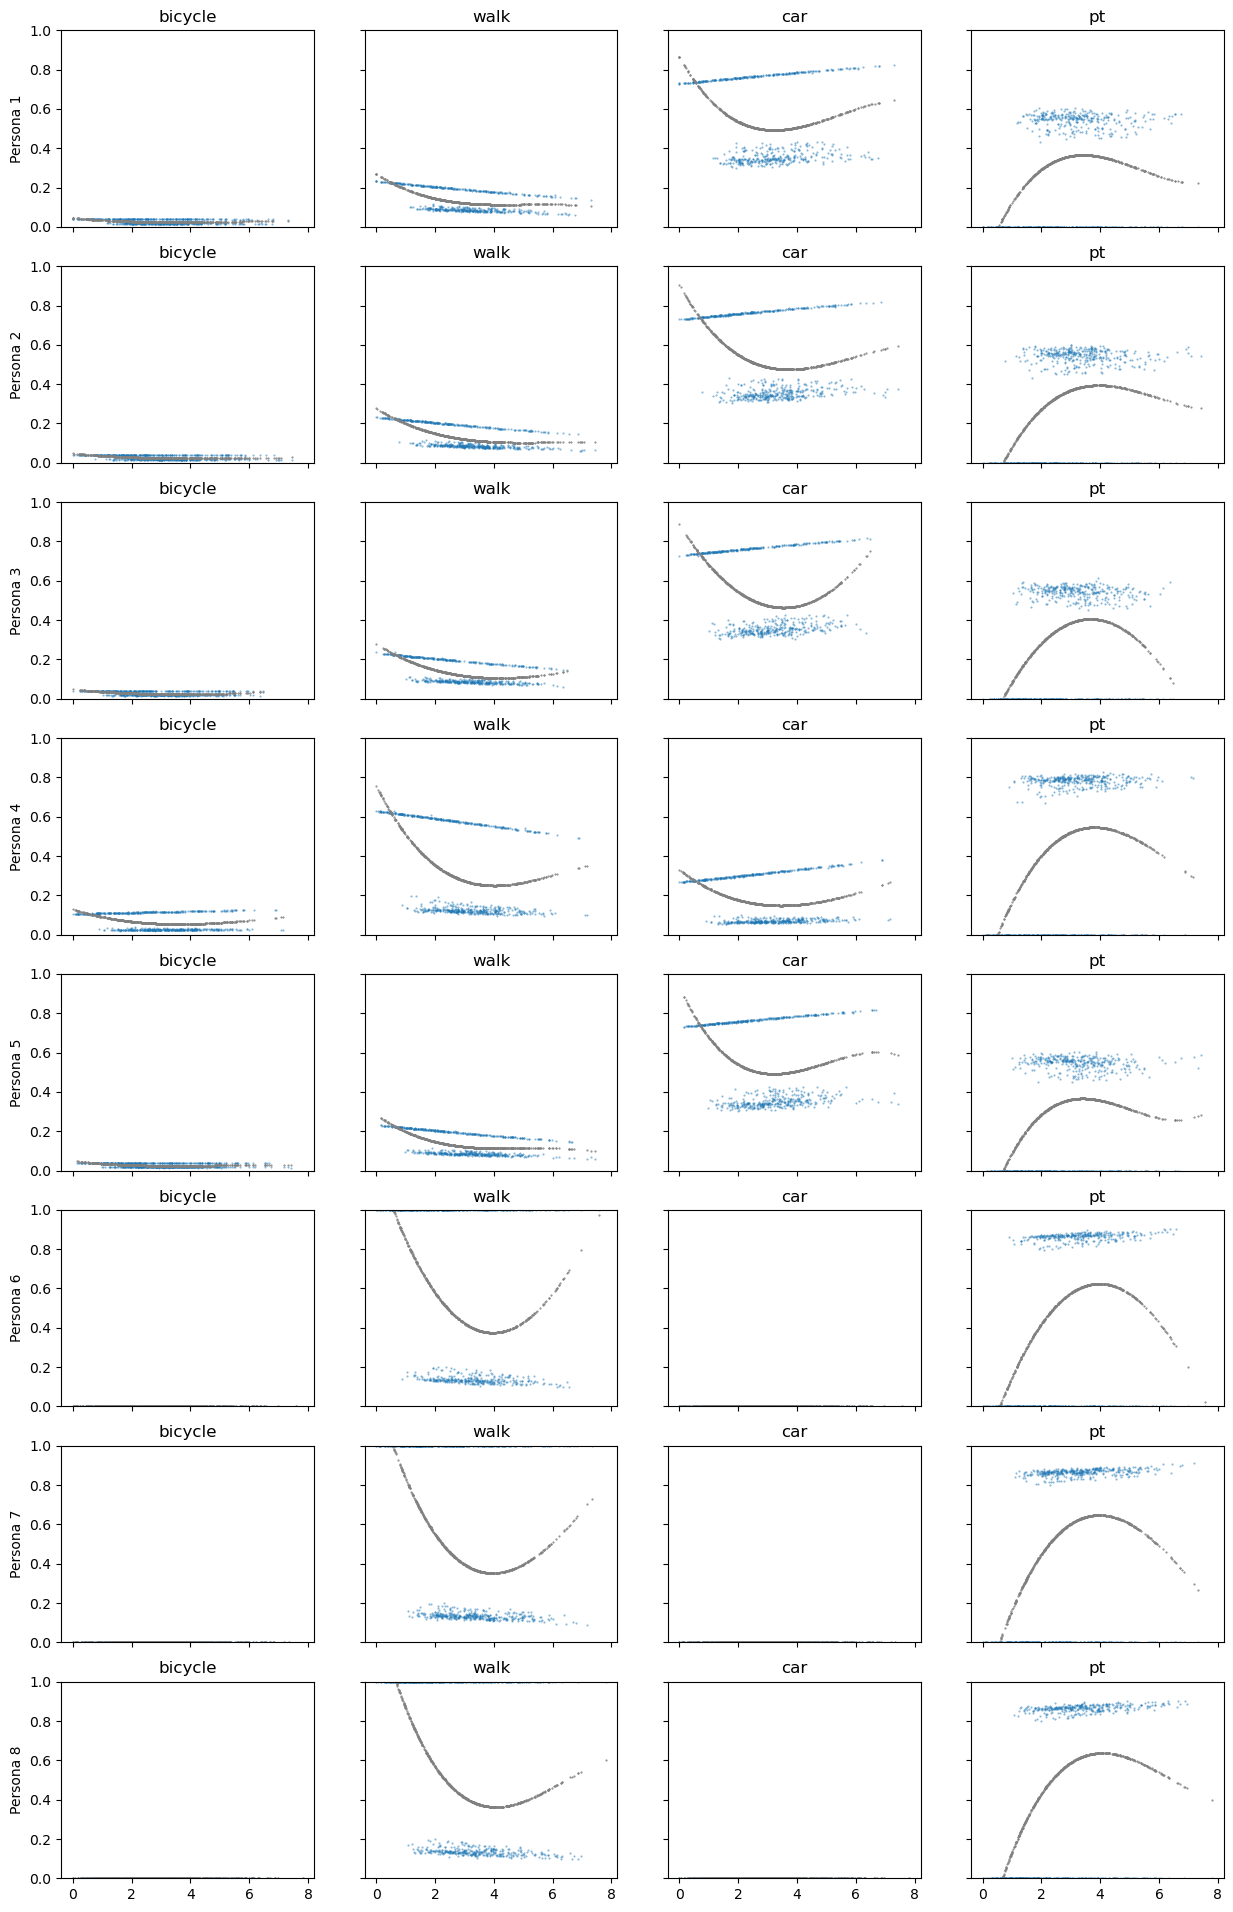

In [13]:
# Distance-distribution of probabilities
merged = model.probabilities.merge( #.sample(max(int(len(model.probabilities)**0.5), 100000))
    model.walk_los[['origin', 'destination', 'length']],
    on=['origin', 'destination'],
    how='inner').sample(min(len(model.walk_los), 5000))
segments = list(model.probabilities['segment'].unique())
if len(segments) == 1: segments = segments * 2
route_types = list(set(model.probabilities.columns).intersection(set(model.los['route_type'])))
fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                        sharex='all', sharey='all', figsize=(15,len(segments)*3))
for j, mode in zip(range(len(route_types)), route_types):
    for i, seg in zip(range(len(segments)), segments):
        x = merged.loc[merged['segment']==seg, 'length'] / 1000
        y = merged.loc[merged['segment']==seg, mode]
        ax[i,j].scatter(x, y, marker='o', s=.3, alpha=.5, label=mode+' '+seg)
        p = np.poly1d(np.polyfit(x, y, deg=3))
        ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
        ax[i,j].set_title(mode)
        ax[i,0].set_ylabel(seg)
        ax[i,0].set_ylim(0,1)
        #ax[i,j].set_xscale('log')
plt.savefig('../output/'+region_name+'/mode_choice_probability_distribution.png', dpi=400)

# Destination choice

For each persona, choose a set of destinations as need satisfiers

In [14]:
# Distribute personas across a number of home locations randomly
# Could be done based on population density
# All personas are distributed across the same home locations
homes = list(np.random.choice(model.volumes.loc[model.volumes['origin_id'].apply(lambda s: len(s) < 6), 'origin_id'].unique(),
                              50, replace=False, p=None))

<Axes: >

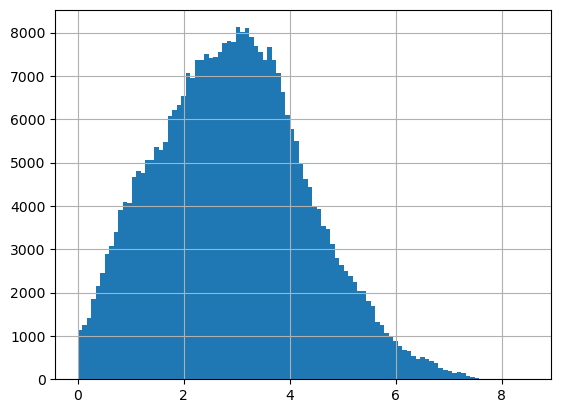

In [15]:
# Get distance from walking paths
model.volumes['distance'] = pd.merge(
    model.volumes, model.walk_los, how='left',
    left_on=['origin_id', 'destination_id'], right_on=['origin', 'destination']
)['length'].fillna(buffer * 2) / 1000
model.volumes = model.volumes.loc[model.volumes['distance'].notna()]
model.volumes['distance'].hist(bins=100)

<Axes: xlabel='distance', ylabel='deterrence'>

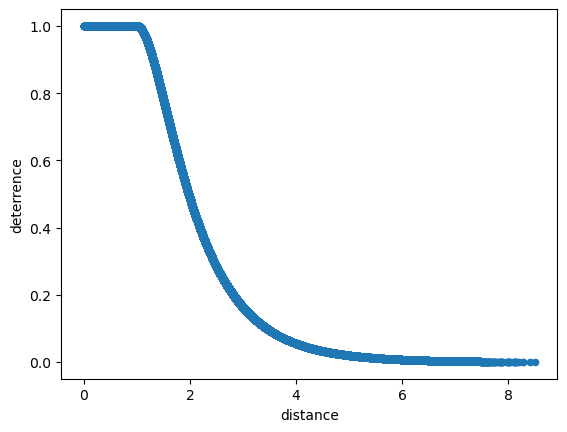

In [16]:
# Create the distance deterrence with a gravity model for each OD pair
a = 1e3
b = 1.5
d = a * np.exp(-b * np.power(np.log(model.volumes['distance'].clip(lower=1)), 2)) # log-normal function
model.volumes['deterrence'] = (d-d.min())/(d.max()-d.min()) # min-max normalisation
model.volumes.plot.scatter(x='distance', y='deterrence')

In [17]:
# Choose one destination for each activity for each home location
# Based on distance deterrence
# Same choice for each persona
activities = list(set(model.volumes['activity'].astype(str)))
activity_dest = {a: [] for a in activities}
for home in homes:
    for activity in activities:
        destinations = model.volumes.loc[(model.volumes['activity'].astype(str)==activity)
                                         & (model.volumes['origin_id']==home)]
        if len(destinations) > 0:
            prob = destinations['deterrence'] * (1 / destinations['deterrence'].sum())
            activity_dest[activity].append(np.random.choice(
                destinations['destination_id'], 1, replace=False, p=prob)[0])
        else:
            activity_dest[activity].append(0)
od_pairs = pd.DataFrame(index=homes, data=activity_dest)
# Number of home-activity combinations without possible destination
assert (od_pairs.values == 0).sum() == 0

# Build trip chains

Apply trip frequencies to construct daily schedules. Trip chains with less than daily trip frequencies have a respectively lower weighting.

In [18]:
# Define a temporal order for activities
# Activities must have the same name as in the POI data
# '0' stands for go home
# For now, the same schedule for all personas
home_activity = '0'
persona_schedule_order = {}
for persona in model.segments:
    persona_schedule_order[persona] = ['1', '2', '6', '3', '51', '52', '42', '41', '7', home_activity]

In [19]:
# Load trip frequencies
trips = pd.read_excel('../input/decent_mobility_trips.xlsx', sheet_name=0, skiprows=1)
trips = trips.loc[trips['name'].notna()].set_index('name')
trips['1'] = trips['Commuting and business']
trips['2'] = trips['Education']
trips['3'] = trips['Accompaniment']
trips['6'] = trips['Healthcare']
trips['7'] = trips['Recreational and outdoors']
trips['41'] = trips['Social and cultural'] / 2
trips['42'] = trips['Social and cultural'] / 2
trips['51'] = trips['Shopping and errands'] / 2
trips['52'] = trips['Shopping and errands'] / 2
trips[home_activity] = trips['Home']
trips = trips[activities + [home_activity]]

In [20]:
# Differentiate trip chains by their frequency
persona_schedules = {p: {} for p in model.segments}
for persona in model.segments:
    freqs = trips.loc[persona].sort_values(ascending=False).to_dict()
    sort_order = dict(zip(persona_schedule_order[persona], range(len(persona_schedule_order[persona]))))
    while len(freqs) > 0:
        act, freq = freqs.popitem() # take the lowest frequency trip
        if freq > 0 and act != home_activity:
            activities_to_do = [a for a,f in freqs.items() if f>=freq and a!=home_activity] + [act, home_activity]
            activities_to_do.sort(key=lambda val: sort_order[val]) # sort by schedule order
            persona_schedules[persona][freq] = activities_to_do.copy()
            freqs = {a: f - freq for a,f in freqs.items()} # update residual frequencies

In [21]:
# Assign trip chains to the networks based on mode choice probabilities
# Take the first leg of the trip chain as mode choice decision criterion
# Perform this for every persona in every home location
results = {}
modes = [c for c in model.probabilities.columns if c in model.los['route_type'].unique()]
for persona in model.segments:
    paths = []
    for home in homes:
        for freq, schedule in persona_schedules[persona].items():
            # Choose mode
            first_dest = od_pairs.loc[home, schedule[0]]
            if isinstance(first_dest, pd.Series): first_dest = first_dest.iloc[0]
            decision_leg = model.probabilities.loc[(model.probabilities['segment']==persona)
                                                & (model.probabilities['origin']==home)
                                                & (model.probabilities['destination']==first_dest)]
            mode = np.random.choice(modes, 1, p=decision_leg[modes].values[0])[0]
            # Look up the travel characteristics of each leg in the corresponding LoS table
            los = model.__dict__[mode.replace('car', 'auto').replace('bicycle', 'cycle')+'_los']
            origin = home
            for activity in schedule:
                destination = od_pairs.loc[home, activity] if activity != home_activity else home
                p = los.loc[(los['origin']==origin) & (los['destination']==destination),
                            ['link_path', 'time', 'route_type', 'route_types', 'length', 'origin', 'destination']]
                p['activity'] = activity
                p['frequency'] = freq
                p['home'] = home
                p['mode'] = p['route_type'].replace({'walk':'active', 'bicycle':'active', 'pt':'PT', 'car':'MIT'})
                paths.append(p)
                origin = destination
        # Put all trips of that persona in that home location together
    results[persona] = pd.concat(paths).reset_index(drop=False)

# Boundary analysis

Apply boundary conditions and analyse decent mobility

In [22]:
'''# Compute aggregate modal split as a measure of trips
for persona in model.segments:
    model.volumes[persona] = model.volumes['deterrence']
model.volumes['origin'] = model.volumes['origin_id']
model.volumes['destination'] = model.volumes['destination_id']
model.compute_los_volume()
modal_split = model.los.groupby('route_type')[model.segments].sum()
modal_split = modal_split / modal_split.sum()
modal_split'''

"# Compute aggregate modal split as a measure of trips\nfor persona in model.segments:\n    model.volumes[persona] = model.volumes['deterrence']\nmodel.volumes['origin'] = model.volumes['origin_id']\nmodel.volumes['destination'] = model.volumes['destination_id']\nmodel.compute_los_volume()\nmodal_split = model.los.groupby('route_type')[model.segments].sum()\nmodal_split = modal_split / modal_split.sum()\nmodal_split"

C:\Users\m.arnz\AppData\Local\Temp\ipykernel_9340\2180975151.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  home_modes.append(data.groupby('mode').apply(lambda g: (g['length']*g['frequency']).sum()))
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_9340\2180975151.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  home_modes.append(data.groupby('mode').apply(lambda g: (g['length']*g['frequency']).sum())

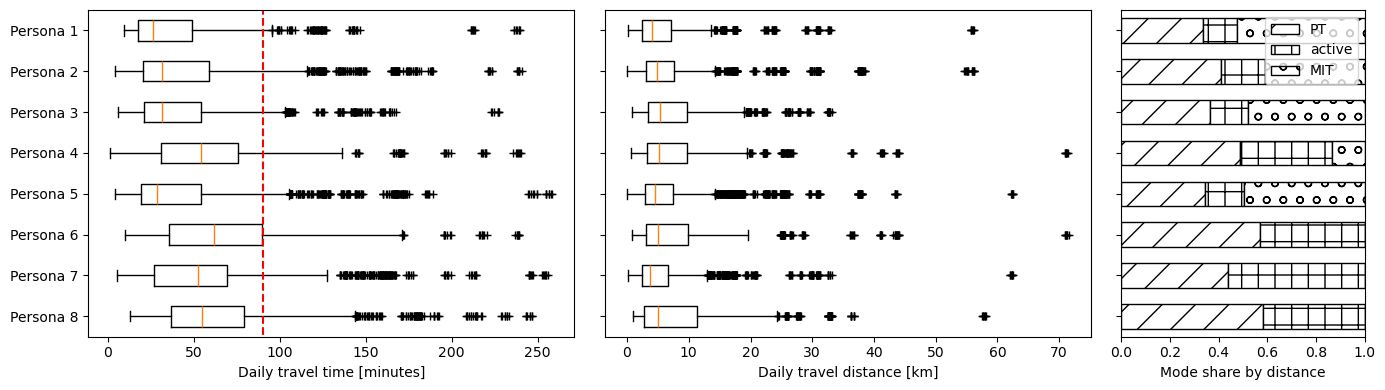

In [23]:
# Persona boxplots
fig, ax = plt.subplots(1, 3, figsize=(14,4), width_ratios=[2,2,1])
times = []
distances = []
mode_list = ['PT', 'active', 'MIT']
mode_shares = pd.DataFrame(index=mode_list)
for persona in model.segments:
    home_times = []
    home_dists = []
    home_modes = []
    for home in results[persona]['home'].unique():
        data = results[persona].loc[results[persona]['home']==home]
        # sum of trip chains / tours, multiplied by frequency as quantity weighting
        home_times.append(sum([list(np.random.uniform(data.loc[data['frequency']==freq, 'time'].sum()-2,
                                                      data.loc[data['frequency']==freq, 'time'].sum()+3,
                                                      int(round(freq*100))))
                                                      for freq in data['frequency'].unique()], []))
        home_dists.append(sum([list(np.random.uniform(data.loc[data['frequency']==freq, 'length'].sum()/1000-0.2,
                                                      data.loc[data['frequency']==freq, 'length'].sum()/1000+0.5,
                                                      int(round(freq*100))))
                                                      for freq in data['frequency'].unique()], []))
        home_modes.append(data.groupby('mode').apply(lambda g: (g['length']*g['frequency']).sum()))
    times.append(sum(home_times, []))
    distances.append(sum(home_dists, []))
    home_modes.append(pd.Series([0 for m in mode_list], index=mode_list))
    mode_shares[persona] = pd.concat(home_modes).groupby(level=0).sum().loc[mode_list]
ax[0].boxplot(times[::-1], sym='+', vert=False)#orientation='horizontal')
ax[0].set_xlabel('Daily travel time [minutes]')
ax[0].set_yticklabels(model.segments[::-1])
ax[0].vlines(x=90, ymin=0, ymax=len(model.segments)+1, colors='red', linestyles='dashed')
ax[0].set_ylim(0.5, 8.5)
ax[1].boxplot(distances[::-1], sym='+', vert=False)#orientation='horizontal')
ax[1].set_xlabel('Daily travel distance [km]')
ax[1].set_ylim(0.5, 8.5)
ax[1].set_yticklabels([])
mode_shares = mode_shares / mode_shares.sum()
for mode, style in zip(mode_list, ['/', '+', 'o']):
    if mode_list.index(mode) == 0:
        left = [0 for p in model.segments]
    else:
        left = mode_shares.loc[:mode].sum()-mode_shares.loc[mode]
    ax[2].barh(list(range(1,len(model.segments)+1))[::-1], mode_shares.loc[mode], left=left,
               height=.6, label=mode, color='white', hatch=style, edgecolor='black')
ax[2].set_ylim(0.5, 8.5)
ax[2].set_yticklabels([])
ax[2].set_xlabel('Mode share by distance')
plt.legend()
fig.tight_layout()
plt.savefig('../output/'+region_name+'/persona_time_distance_modes.png', dpi=400)

Text(0, 0.5, 'km/cap/year')

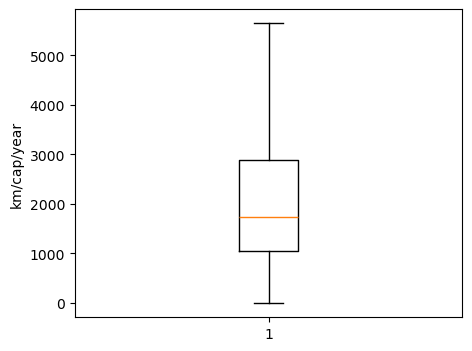

In [24]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
dist_agg = sum([[d*365 for d in l] for l in distances[::-1]], [])
ax.boxplot(dist_agg, sym='')
ax.set_ylabel('km/cap/year')

In [42]:
# Maps with decent mobility by persona and home location
time_thresh = 90
residential = gpd.read_file('../model/'+region_name+'/residential.geojson', crs='EPSG:4326')
streets = model.walk_links.loc[model.walk_links['geometry'].within(model.study_region_polygon)]
home_geos = gpd.GeoDataFrame(model.volumes.loc[model.volumes['origin_id'].apply(lambda s: len(s)<6), ['origin_id', 'origin']],
                             geometry='origin', crs="EPSG:4326").drop_duplicates('origin_id').set_index('origin_id')
for persona in model.segments:
    def proportion_decent_mobility(trips):
        time = trips.groupby('frequency')['time'].sum()
        return len(time.loc[time<=time_thresh]) / len(time)
    data = results[persona].groupby('home').apply(proportion_decent_mobility)
    home_geos[persona] = home_geos.index.map(data)

c:\Users\m.arnz\AppData\Local\miniforge-pypy3\envs\quetzal\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_9340\1926671075.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = results[persona].groupby('home').apply(proportion_decent_mobility)
C:\Users\m.arnz\AppData\Local\Temp\ipykernel_9340\1926671075.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicit

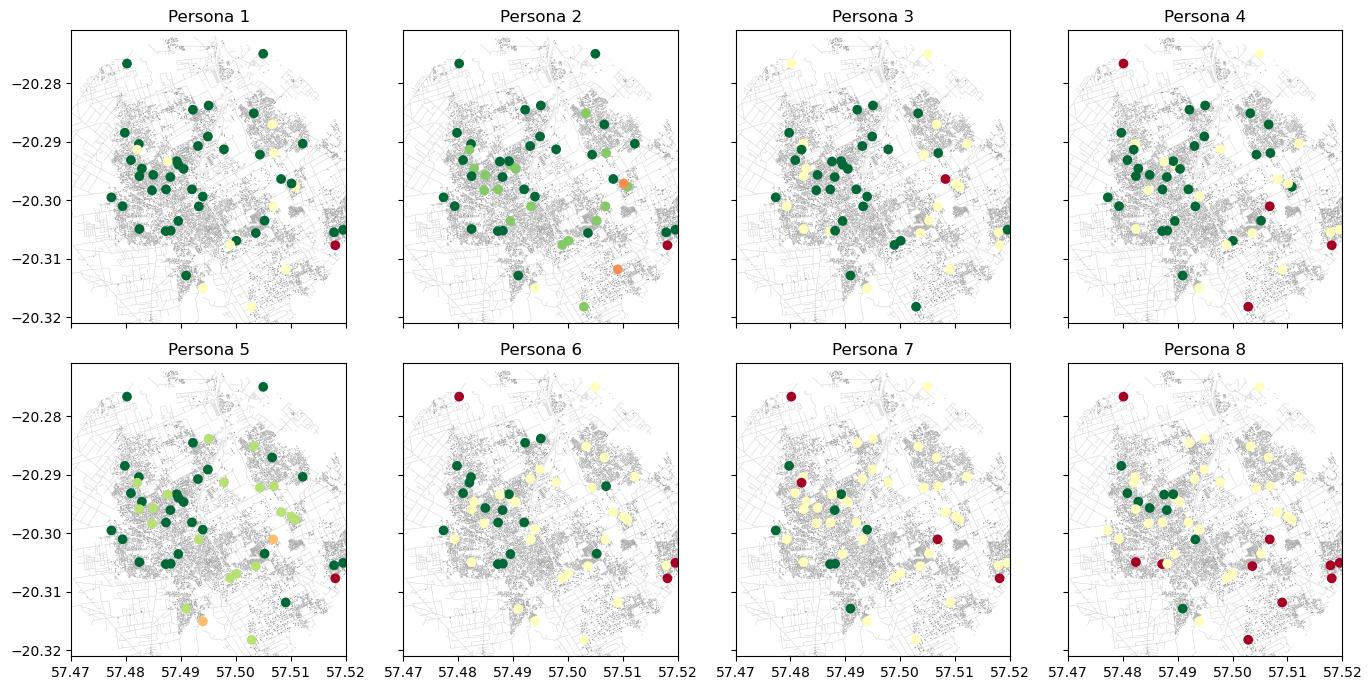

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=int(len(model.segments)/2), figsize=(14,7), sharex='all', sharey='all')
for ax, persona in zip(axs.flat, model.segments):
    streets.plot(color='lightgrey', linewidth=.2, ax=ax, zorder=-2)
    residential.plot(color='grey', ax=ax, zorder=-1)
    home_geos.plot(column=persona, cmap='RdYlGn', ax=ax, zorder=0)
    ax.set_title(persona)
    ax.set_xlim(57.47, 57.52)
    ax.set_ylim(-20.321, -20.271)
fig.tight_layout()
plt.savefig('../output/'+region_name+'/decent_mobility_maps.png', dpi=400)

In [25]:
# Save data
for persona in model.segments:
    results[persona].to_csv('../output/'+region_name+'/'+persona+'.csv')